# はじめに
表形式データの分類モデルを構築します。

### 概要
- adultデータセットを用いて収入を予測するモデルを構築します。
- モデルは全結合ニューラルネットワークを使用します。

# 実装
### 1. ライブラリのインポート


In [2]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  

In [3]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch: 2.1.0+cu121
Sat Dec 16 03:37:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |            

### 3. データセットの用意
adultデータセットをダウンロードして、学習に使用できる形式に整形します。

In [10]:
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets['income']

y = y.replace({'<=50K.': 0, '<=50K':0, '>50K.': 1, '>50K': 1})

# カテゴリ変数の特定
categorical = X.columns[X.dtypes == 'object']
continuous = X.columns[X.dtypes != 'object']

# 連続値を平均0分散1に標準化
X[continuous] = (X[continuous] - X[continuous].mean()) / X[continuous].std()

# カテゴリ変数をone-hot encoding
X = pd.get_dummies(X, columns=categorical, dtype=float, drop_first=True)

# 教師データとテストデータにランダムに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)
print(collections.Counter(y_train), collections.Counter(y_test))

# PyTorchのテンソルに変換
X_train = torch.from_numpy(X_train.values).to(torch.float32)
y_train = torch.from_numpy(y_train.values).to(torch.int64)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

X_test = torch.from_numpy(X_test.values).to(torch.float32)
y_test = torch.from_numpy(y_test.values).to(torch.int64)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)


<ipython-input-10-43eac89dd8f8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous] = (X[continuous] - X[continuous].mean()) / X[continuous].std()


(34189, 100) (14653, 100)
Counter({0: 26046, 1: 8143}) Counter({0: 11109, 1: 3544})


### 4. ニューラルネットワークの定義  
今回は5層の全結合ニューラルネットワークを用います。

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


### 5. 学習
ニューラルネットワークの学習を行います。  


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
for epoch in range(30):
    # 学習
    epoch_loss = []
    pred_list = []
    y_list = []
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 順伝播と損失の計算
        pred = model(inputs)
        loss = criterion(pred, targets)

        # 勾配の初期化と逆伝播
        optimizer.zero_grad()
        loss.backward()

        # パラメータの更新
        optimizer.step()

        epoch_loss.append(loss.item())
        y_list.extend(targets.to('cpu').numpy().tolist())
        pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    train_loss.append(np.mean(epoch_loss))
    train_acc.append(metrics.accuracy_score(y_list, pred_list))

    # テスト
    model.eval()
    epoch_loss = []
    pred_list = []
    y_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            pred = model(inputs)
            loss = criterion(pred, targets)

            epoch_loss.append(loss.item())
            y_list.extend(targets.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(metrics.accuracy_score(y_list, pred_list))
    print(f'[Epoch {epoch}] Train accuracy: {train_acc[-1]:0.2f}, Test accuracy: {test_acc[-1]:0.2f}, Train loss: {train_loss[-1]:0.3f}, Testloss: {test_loss[-1]:0.3f}')


[Epoch 0] Train accuracy: 0.83, Test accuracy: 0.85, Train loss: 0.354, Testloss: 0.319
[Epoch 1] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.309, Testloss: 0.313
[Epoch 2] Train accuracy: 0.86, Test accuracy: 0.85, Train loss: 0.303, Testloss: 0.318
[Epoch 3] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.301, Testloss: 0.316
[Epoch 4] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.299, Testloss: 0.311
[Epoch 5] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.296, Testloss: 0.310
[Epoch 6] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.294, Testloss: 0.318
[Epoch 7] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.290, Testloss: 0.315
[Epoch 8] Train accuracy: 0.86, Test accuracy: 0.86, Train loss: 0.288, Testloss: 0.309
[Epoch 9] Train accuracy: 0.87, Test accuracy: 0.86, Train loss: 0.285, Testloss: 0.315
[Epoch 10] Train accuracy: 0.87, Test accuracy: 0.85, Train loss: 0.282, Testloss: 0.318
[Epoch 11] Train accuracy: 0.87

### 6. 学習結果の表示
学習結果として、教師データとテストデータの損失と精度を描画します。

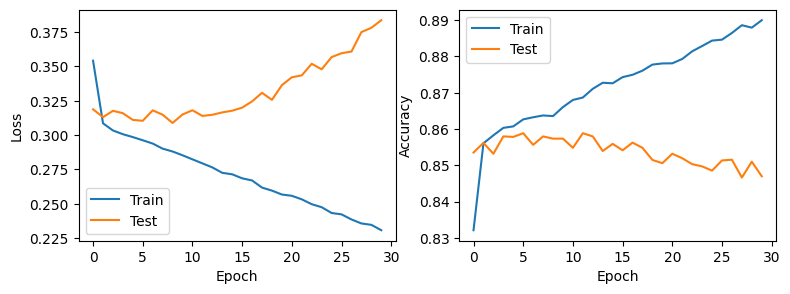

In [23]:

plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# おわりに
### 今回の結果
今回の設定では、テスト精度は85%程度となりました。  
テスト精度と損失が徐々に悪化しているため、過学習気味なことも分かります。


### 次にやること
表形式データのために提案されたニューラルネットワークを試してみようと思います。
